# Coursework 1 - Ethics

## Setup

In [2]:
!pip install 'aif360[LFR]'
!pip install folktables

Keyring is skipped due to an exception: 'keyring.backends'
ERROR: Invalid requirement: "'aif360[LFR]'"


  Using cached folktables-0.0.11.tar.gz (10 kB)
  Created wheel for folktables: filename=folktables-0.0.11-py3-none-any.whl size=6782 sha256=675ef61499006adb4f982c31b229d69273a3e3a784423c6c74fa184c58964ae3
  Stored in directory: c:\users\ashou\appdata\local\pip\cache\wheels\bd\63\b8\24d3f5d2c70002c68c1fe8e78e1de20fcbcb7a2ef3f56147b7
Successfully built folktables


Keyring is skipped due to an exception: 'keyring.backends'


In [53]:
# Run this if folktables can't be installed 
import os
!git clone https://github.com/zykls/folktables.git
os.chdir("folktables")
!pip install -r requirements.txt

Cloning into 'folktables'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 371 (delta 90), reused 80 (delta 75), pack-reused 251
Receiving objects: 100% (371/371), 1.26 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (199/199), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/folktables (from -r requirements.txt (line 1))
  Preparing metadata (setup.py) ... done
  Attempting uninstall: folktables
    Found existing installation: folktables 0.0.11
    Uninstalling folktables-0.0.11:
      Successfully uninstalled folktables-0.0.11
  Running setup.py develop for folktables


In [ ]:
# Run this if aif360 can't be installed
!pip install aif360[LFR]

In [3]:
# Datsets
import folktables
from folktables import ACSDataSource
import aif360
from aif360.datasets import StandardDataset

# Plotting and data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
import os

# Preprocessing and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# Other
import pandas as pd
import itertools 
import random 
import pickle
import random


## Data loading

### Helper functions

In [4]:
# Helper functions

#(Age) must be greater than 16 and less than 90, and (Person weight) must be
# greater than or equal to 1
def employment_filter(data):
    """ Filters for the employment prediction task. """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

In [5]:
def acc_score(rates_1, rates_2):
    dist_1 = np.linalg.norm(np.array(rates_1) - np.array([0,1]))
    dist_2 = np.linalg.norm(np.array(rates_2) - np.array([0,1]))
    return dist_1 + dist_2

def custom_metric(rates_1, rates_2, weight=None):
    acc = acc_score(rates_1, rates_2)
    EO = abs(rates_1[0] - rates_2[0])
    if weight is None:
        return acc - EO
    else:
        return (1-weight)*acc - weight*EO        

def custom_metric_simple(accuracy, fairness, weight=None):
    if weight is None:
        return accuracy - fairness
    return (1-weight)*accuracy - weight*abs(fairness)

In [6]:
def find_tpr_fpr(y_pred, y_labels, sex_split):
    # Subset the y_pred so it only contains the predictions for the privileged group
    inds_1 = np.where(sex_split == 1)[0]
    y_pred_1 = y_pred[inds_1]

    # Subset the y_pred so it only contains the predictions for the unprivileged group
    inds_2 = np.where(sex_split == 2)[0]
    y_pred_2 = y_pred[inds_2]

    # Do the same with the labels
    y_labels_1 = y_labels[inds_1]
    y_labels_2 = y_labels[inds_2]

    # Make sure the shapes are the same
    y_labels_1 = y_labels_1.reshape(y_pred_1.shape)
    y_labels_2 = y_labels_2.reshape(y_pred_2.shape)

    # Find the true positive rate for each group
    tpr_1 = np.sum((y_pred_1 == 1) & (y_labels_1 == 1)) / np.sum(y_labels_1 == 1)
    tpr_2 = np.sum((y_pred_2 == 1) & (y_labels_2 == 1)) / np.sum(y_labels_2 == 1)

    # Find the false positive rate for each group
    fpr_1 = np.sum((y_pred_1 == 1) & (y_labels_1 == 0)) / np.sum(y_labels_1 == 0)
    fpr_2 = np.sum((y_pred_2 == 1) & (y_labels_2 == 0)) / np.sum(y_labels_2 == 0)

    results = [(tpr_1, fpr_1), (tpr_2, fpr_2)]
    return results


In [7]:
def get_results(model, param_space, splits, sex_splits = None, hordtz=False):
    """ Function which finds the results for different hyperparameters
    for a given model from sklearn, given a parameter space and a list of
    splits of the training data.
    """                
    np.random.seed(1)
    results = {}
    fairness_results = {}
    if hordtz:
        hordtz_results = {}
    count = 0   
    for params in ParameterGrid(param_space):
        # Initialize lists to store the results
        accuracies = []
        fairnessess = []
        tpr_1 = []
        fpr_1 = []
        tpr_2 = []
        fpr_2 = []     
        for i, split in enumerate(splits):
            # Each split is a tuple of (train, val) StandardDataset objects
            train_split = split[0]
            val_split = split[1]
            # Train the model
            model.set_params(**params)
            model.fit(train_split.features, train_split.labels.ravel())
            # Evaluate the model
            y_pred = model.predict(val_split.features)
            accuracy = accuracy_score(val_split.labels, y_pred)
            accuracies.append(accuracy)
            # Find the equality of opportunity metric for this prediction
            pred_dataset = val_split.copy()
            pred_dataset.labels = y_pred                
            fairness = ClassificationMetric(val_split, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)                
            # Add the fairness to the list of fairnesses for this combination of params
            fairnessess.append(fairness.equal_opportunity_difference())
            # Print the results   
            if count % 10 == 0:
                print("params: {}, accuracy: {}, fairness: {}".format(params, accuracy, fairness.equal_opportunity_difference()))
                print("Iteration: ", count)
            count += 1

            # If horodtz results are required, do following
            if hordtz:
                # Obtain results for TPR and FPR for individual groups
                gen_split = sex_splits[i][1]
                rates = find_tpr_fpr(y_pred, val_split.labels, gen_split)   

                # Add the results to the list
                tpr_1.append(rates[0][0])
                fpr_1.append(rates[0][1])
                tpr_2.append(rates[1][0])
                fpr_2.append(rates[1][1])         


        # Find the mean accuracy and mean fairness for this combination of params
        mean_accuracy = np.mean(accuracies)
        mean_fairness = np.mean(fairnessess)

        # Add the mean accuracy and mean fairness to the results dictionary
        results[tuple(params.items())] = mean_accuracy
        fairness_results[tuple(params.items())] = mean_fairness

        # If horodtz results are required, do following
        if hordtz:
            # Find the mean TPR and FPR for each group
            mean_tpr_1 = np.mean(tpr_1)
            mean_fpr_1 = np.mean(fpr_1)
            mean_tpr_2 = np.mean(tpr_2)
            mean_fpr_2 = np.mean(fpr_2)

            # Add the mean TPR and FPR to the results dictionary
            hordtz_results[tuple(params.items())] = (mean_tpr_1, mean_fpr_1, mean_tpr_2, mean_fpr_2)

    if hordtz:
        return results, fairness_results, hordtz_results
    else:
        return results, fairness_results

In [8]:
def get_results_weighted(model, param_space, splits, sex_splits = None, hordtz=False):
    """ Function which finds the results for different hyperparameters
    for a given model from sklearn, given a parameter space and a list of
    splits of the training data.
    """            
    np.random.seed(1)
    results = {}
    fairness_results = {}
    if hordtz:
        hordtz_results = {}
    count = 0
    for params in ParameterGrid(param_space):
        # Initialize lists to store the results
        accuracies = []
        fairnessess = []
        tpr_1 = []
        fpr_1 = []
        tpr_2 = []
        fpr_2 = []
        for i, split in enumerate(splits):
            # Each split is a tuple of (train, val) StandardDataset objects
            train_split = split[0]
            val_split = split[1]
            # Weighting
            RW = Reweighing(unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)
            #We obtain a set of weights for the training set, to use in scikit-learn.
            train_split = RW.fit_transform(train_split)
            # Train the model
            model.set_params(**params)
            model.fit(train_split.features, train_split.labels.ravel(), sample_weight=train_split.instance_weights)
            # Evaluate the model
            y_pred = model.predict(val_split.features)
            accuracy = accuracy_score(val_split.labels, y_pred)
            accuracies.append(accuracy)
            # Find the equality of opportunity metric for this prediction
            pred_dataset = val_split.copy()
            pred_dataset.labels = y_pred                
            fairness = ClassificationMetric(val_split, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)                
            # Add the fairness to the list of fairnesses for this combination of params
            fairnessess.append(fairness.equal_opportunity_difference())
            # Print the results
            if count % 10 == 0:
                print("params: {}, accuracy: {}, fairness: {}".format(params, accuracy, fairness.equal_opportunity_difference()))
                print("Iteration: ", count)
            count += 1

            # If horodtz results are required, do following
            if hordtz:
                # Obtain results for TPR and FPR for individual groups
                gen_split = sex_splits[i][1]
                rates = find_tpr_fpr(y_pred, val_split.labels, gen_split)   

                # Add the results to the list
                tpr_1.append(rates[0][0])
                fpr_1.append(rates[0][1])
                tpr_2.append(rates[1][0])
                fpr_2.append(rates[1][1])         


        # Find the mean accuracy and mean fairness for this combination of params
        mean_accuracy = np.mean(accuracies)
        mean_fairness = np.mean(fairnessess)

        # Add the mean accuracy and mean fairness to the results dictionary
        results[tuple(params.items())] = mean_accuracy
        fairness_results[tuple(params.items())] = mean_fairness

        # If horodtz results are required, do following
        if hordtz:
            # Find the mean TPR and FPR for each group
            mean_tpr_1 = np.mean(tpr_1)
            mean_fpr_1 = np.mean(fpr_1)
            mean_tpr_2 = np.mean(tpr_2)
            mean_fpr_2 = np.mean(fpr_2)

            # Add the mean TPR and FPR to the results dictionary
            hordtz_results[tuple(params.items())] = (mean_tpr_1, mean_fpr_1, mean_tpr_2, mean_fpr_2)

    if hordtz:
        return results, fairness_results, hordtz_results
    else:
        return results, fairness_results

def get_feature_index(feature_name, features):
    """ Function which returns the index of a feature in the dataset
    """
    for i, feature in enumerate(features):
        if feature == feature_name:
            return i
    return None

### Loading data

In [355]:
# Loading the data

features_names=[
            'AGEP', #age; for range of values of features please check Appendix B.4 of
            # Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
            'SCHL', #educational attainment
            'MAR', #marital status
            'RELP', #relationship
            'DIS', #disability recode
            'ESP', #employment status of parents
            'CIT', #citizenship status
            'MIG', #mobility status (lived here 1 year ago)
            'MIL', #military service
            'ANC', #ancestry recode
            'NATIVITY', #nativity
            'DEAR', #hearing difficulty
            'DEYE', #vision difficulty
            'DREM', #cognitive difficulty
            'SEX', #sex
            'RAC1P', #recoded detailed race code
            'GCL', #grandparents living with grandchildren
            ]
ACSEmployment = folktables.BasicProblem(
    features=[
            'AGEP', #age; for range of values of features please check Appendix B.4 of
            # Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
            'SCHL', #educational attainment
            'MAR', #marital status
            'RELP', #relationship
            'DIS', #disability recode
            'ESP', #employment status of parents
            'CIT', #citizenship status
            'MIG', #mobility status (lived here 1 year ago)
            'MIL', #military service
            'ANC', #ancestry recode
            'NATIVITY', #nativity
            'DEAR', #hearing difficulty
            'DEYE', #vision difficulty
            'DREM', #cognitive difficulty
            'SEX', #sex
            'RAC1P', #recoded detailed race code
            'GCL', #grandparents living with grandchildren
            ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
    )

# CA data
if os.path.isfile('acs_data.csv'):
    acs_data = pd.read_csv('acs_data.csv')
    features, label, group = ACSEmployment.df_to_numpy(acs_data)
else:
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=True) #data for California state
    features, label, group = ACSEmployment.df_to_numpy(acs_data)

# NY data
if os.path.isfile('acs_data_ny.csv'):
    acs_data_ny = pd.read_csv('acs_data_ny.csv')
    features_ny, label_ny, group_ny = ACSEmployment.df_to_numpy(acs_data_ny)
else:
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data_ny = data_source.get_data(states=["NY"], download=True)
    features_ny, label_ny, group_ny = ACSEmployment.df_to_numpy(acs_data_ny)


## Data processing

In [356]:
# For CA
np.random.seed(1)
dataset = pd.DataFrame(features, columns=ACSEmployment.features)
dataset['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = [[1]]

# Loading the data
dataset = StandardDataset(dataset, label_name='label', favorable_classes=favorable_classes, privileged_classes=privileged_classes,
                          protected_attribute_names=protected_attribute_names)

# Privileged and unprivileged groups
privileged_groups = [{"SEX": 1}]
unprivileged_groups = [{"SEX": 2}]

In [357]:
#CA: Splitting the data using aif360
train, test = dataset.split([0.7], shuffle=True)

# Store the array of SEX values for the test and train data - i.e. the values for the sex feature
sex_index = get_feature_index("SEX", dataset.feature_names)
sex_train = train.features[:, sex_index]
sex_test = test.features[:, sex_index]

# Fit scaler on training data - transformation is done after splitting the data
scaler = StandardScaler()
scaler.fit(train.features)

# Creating 5 80-20 splits of the training data for cross validation
# Store the splits for the sex feature
splits = []
sex_splits = []
for i in range(5):
    train_split, val_split = train.split([0.8], shuffle=True)
    # Get the sex feature for the split also
    sex_train_split = train_split.features[:, sex_index].copy()
    sex_val_split = val_split.features[:, sex_index].copy()

    # Add the split to the list
    splits.append((train_split, val_split))
    sex_splits.append((sex_train_split, sex_val_split))


# Fit scaler on traning and test
train.features = scaler.transform(train.features)
test.features = scaler.transform(test.features)

# Create weighted dataset
train_weighted = train.copy(deepcopy=True)
RW = Reweighing(unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)
train_weighted = RW.fit_transform(train_weighted)            

# Do the same for each split
for i in range(5):
    splits[i][0].features = scaler.transform(splits[i][0].features)
    splits[i][1].features = scaler.transform(splits[i][1].features)

In [358]:
# For NY
dataset_ny = pd.DataFrame(features_ny, columns=ACSEmployment.features)
dataset_ny['label'] = label_ny
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = [[1]]

# Loading the data
dataset_ny = StandardDataset(dataset_ny, label_name='label', favorable_classes=favorable_classes, privileged_classes=privileged_classes,
                            protected_attribute_names=protected_attribute_names)  

# NY privileged and unprivileged groups
sex_index_ny = get_feature_index("SEX", dataset_ny.feature_names)
sexes_ny = dataset_ny.features[:, sex_index_ny]

# Apply standard scaling to the data
scaler = StandardScaler()
dataset_ny.features = scaler.fit_transform(dataset_ny.features)      


In [264]:
#CA: Splitting the data using aif360
train, test = dataset.split([0.7], shuffle=True)

# Store the array of SEX values for the test and train data - i.e. the values for the sex feature
sex_index = get_feature_index("SEX", dataset.feature_names)
sex_train = train.features[:, sex_index]
sex_test = test.features[:, sex_index]

# Fit scaler on training data - transformation is done after splitting the data
scaler = StandardScaler()
scaler.fit(train.features)

# Creating 5 80-20 splits of the training data for cross validation
# Store the splits for the sex feature
splits = []
sex_splits = []
for i in range(5):
    train_split, val_split = train.split([0.8], shuffle=True)
    # Get the sex feature for the split also
    sex_train_split = train_split.features[:, sex_index].copy()
    sex_val_split = val_split.features[:, sex_index].copy()

    # Add the split to the list
    splits.append((train_split, val_split))
    sex_splits.append((sex_train_split, sex_val_split))

## Explanatory data analysis

### California dataset

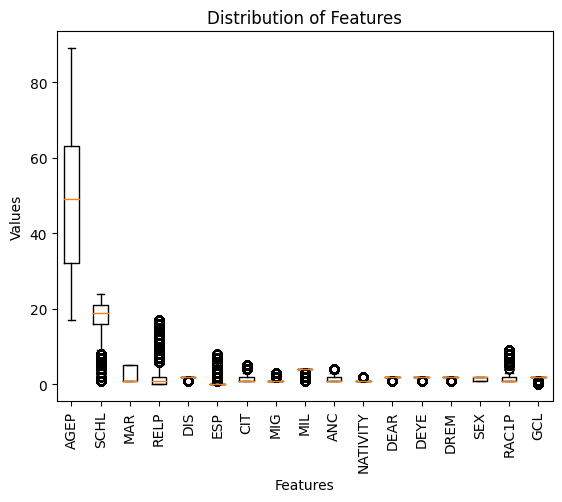

In [362]:
import seaborn as sns 

dataset_ny = pd.DataFrame(features_ny, columns=ACSEmployment.features)

feats = [col for col in dataset_ny.columns if col != 'label']

plt.boxplot([dataset_ny[col] for col in feats], labels=feats)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Distribution of Features')
plt.show()



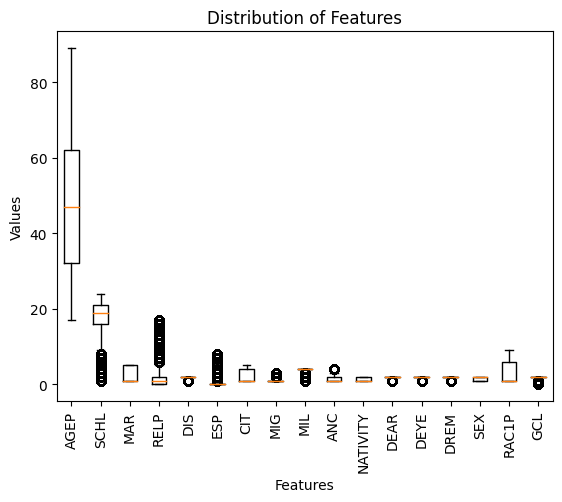

In [132]:
import seaborn as sns

dataset = pd.DataFrame(features, columns=ACSEmployment.features)

feats = [col for col in dataset.columns if col != 'label']

plt.boxplot([dataset[col] for col in feats], labels=feats)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Distribution of Features')
plt.show()


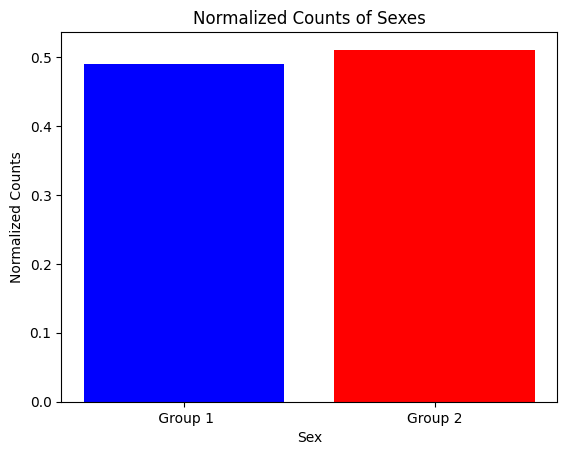

In [151]:
gender_index = get_feature_index("SEX", dataset.feature_names)
genders = dataset.features[:, gender_index]

# Plot the distribution of genders, normalized
unique, counts = np.unique(genders, return_counts=True)
plt.bar(unique[0], counts[0]/genders.shape[0], align='center', color='blue')
plt.bar(unique[1], counts[1]/genders.shape[0], align='center', color='red')
plt.xticks(unique, [ ' Group 1', 'Group 2'])
plt.xlabel('Sex')
plt.ylabel('Normalized Counts')
plt.title('Normalized Counts of Sexes')
plt.show()

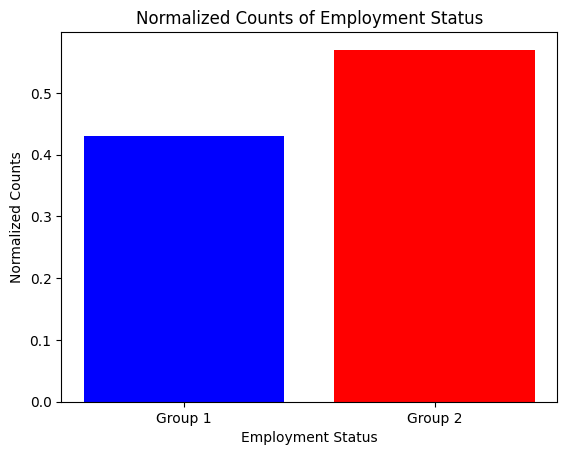

In [154]:
emp = dataset.labels

# Plot the distribution of genders, normalized
unique, counts = np.unique(emp, return_counts=True)
plt.bar(unique[0], counts[0]/emp.shape[0], align='center', color='blue')
plt.bar(unique[1], counts[1]/emp.shape[0], align='center', color='red')
plt.xticks(unique, [ 'Group 1', 'Group 2'])
plt.xlabel('Employment Status')
plt.ylabel('Normalized Counts')
plt.title('Normalized Counts of Employment Status')
plt.show()

In [155]:
counts[0]/emp.shape[0], counts[1]/emp.shape[0]

(0.4301612476870209, 0.5698387523129791)

### NY dataset

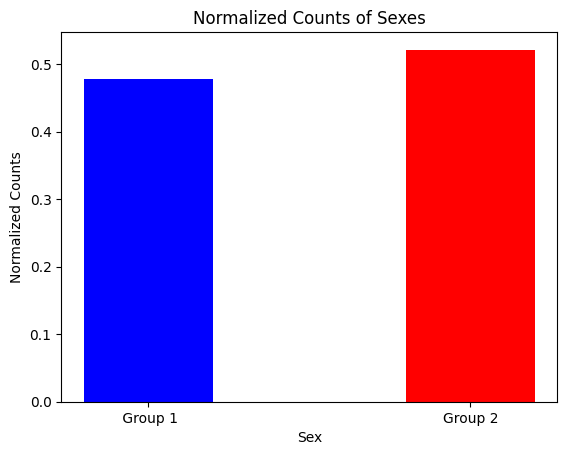

In [158]:
gender_index = get_feature_index("SEX", dataset_ny.feature_names)
genders = dataset_ny.features[:, gender_index]

# Plot the distribution of genders, normalized
unique, counts = np.unique(genders, return_counts=True)
plt.bar(unique[0], counts[0]/genders.shape[0], align='center', color='blue')
plt.bar(unique[1], counts[1]/genders.shape[0], align='center', color='red')
plt.xticks(unique, [ ' Group 1', 'Group 2'])
plt.xlabel('Sex')
plt.ylabel('Normalized Counts')
plt.title('Normalized Counts of Sexes')
plt.show()

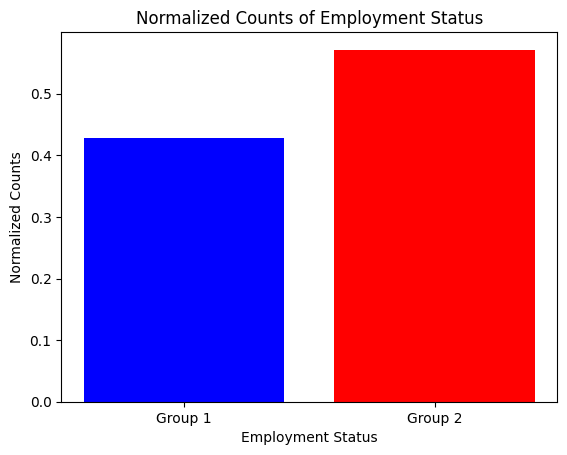

In [159]:
emp = dataset_ny.labels

# Plot the distribution of genders, normalized
unique, counts = np.unique(emp, return_counts=True)
plt.bar(unique[0], counts[0]/emp.shape[0], align='center', color='blue')
plt.bar(unique[1], counts[1]/emp.shape[0], align='center', color='red')
plt.xticks(unique, [ 'Group 1', 'Group 2'])
plt.xlabel('Employment Status')
plt.ylabel('Normalized Counts')
plt.title('Normalized Counts of Employment Status')
plt.show()

In [160]:
counts[0]/emp.shape[0], counts[1]/emp.shape[0]

(0.42864483785054047, 0.5713551621494595)

## Task 1 - Model selection

We will train a logistic regression model and choose the best model based on 1) the mean accuracy on the validation splits 
and 2) the mean equality of opportunity metric on the validation splits

### Experiments

In [142]:
params = {'C': [1e-20, 1e-10, 1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e5, 1e10, 1e20], 
        'penalty': ['l1'], "solver": ['saga']}        

np.random.seed(1)
model = LogisticRegression()
results, fairness_results, hordtz_results = get_results(model, params, splits, sex_splits = sex_splits, hordtz=True)             

params: {'C': 1e-20, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  0
params: {'C': 1e-10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  10
params: {'C': 1e-05, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  20
params: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7230115647864055, fairness: -0.11151804347849925
Iteration:  30
params: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.725041302808591, fairness: -0.12923894394162216
Iteration:  40
params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.725584139721501, fairness: -0.13251286117389538
Iteration:  50
params: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7257021477460467, fairness: -0.13234696957733316
Iteration:  60
params: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7257021477460467, fairness: -0.13226910614978515
Iteration:  70


In [ ]:
# Store results in a dataframe
results_df = pd.DataFrame(columns=['C', 'penalty', 'solver', 'accuracy', 'fairness', 'tpr_1', 'fpr_1', 'tpr_2', 'fpr_2'])
for key, value in results.items():
    params = dict(key)
    results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results[key], 'tpr_1': hordtz_results[key][0], 'fpr_1': hordtz_results[key][1], 'tpr_2': hordtz_results[key][2], 'fpr_2': hordtz_results[key][3]}, ignore_index=True)
    
# Save the results to a csv
results_df.to_csv('LR_results_task_1.csv')

In [265]:
# Load the results
results_df = pd.read_csv('LR_results_task_1.csv')

# Get results when maximizing for accuracy
results_df_l1_acc = results_df_l1[results_df_l1['accuracy'] == results_df_l1['accuracy'].max()]
results_df_l1_acc = results_df_l1_acc.iloc[0]

# Print the results and parameters for maximizing for accuracy
print("Maximizing for accuracy:")
print("Best accuracy: ", results_df_l1_acc['accuracy'])
print("Parameters: ", results_df_l1_acc[['C', 'penalty', 'solver']])
print("Fairness: ", results_df_l1_acc['fairness'])
print()


# Get results when minimizing for the absolute value of fairness
results_df_l1_fair = results_df_l1[results_df_l1['fairness'] == results_df_l1['fairness'].abs().min()]
results_df_l1_fair = results_df_l1_fair.iloc[0]
print("Minimizing for fairness:")
print("Best fairness: ", results_df_l1_fair['fairness'])
print("Parameters: ", results_df_l1_fair[['C', 'penalty', 'solver']])
print("Accuracy: ", results_df_l1_fair['accuracy'])


Maximizing for accuracy:
Best accuracy:  0.7284399339155063
Parameters:  C          10000000000.0
penalty               l1
solver              saga
Name: 22, dtype: object
Fairness:  -0.1212138803773035

Minimizing for fairness:
Best fairness:  0.0
Parameters:  C           0.0
penalty      l1
solver     saga
Name: 0, dtype: object
Accuracy:  0.5701534104319094


In [214]:
# Train the model with the best parameters

best_params = [(results_df_l1_acc['C'], results_df_l1_acc['penalty'], results_df_l1_acc['solver'])]
model = LogisticRegression(C=best_params[0][0], penalty=best_params[0][1], solver=best_params[0][2], max_iter=10000)
model.fit(train.features, train.labels.ravel())
pickle.dump(model, open("accurate_model_1.pkl", "wb"))

# Evaluate the model on the test set
y_pred = model.predict(test.features)
accuracy = accuracy_score(test.labels, y_pred)
print("Accuracy: {}".format(accuracy))

# Fairness
pred_dataset = test.copy()
pred_dataset.labels = y_pred
fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Fairness: {}".format(fairness.equal_opportunity_difference()))

Accuracy: 0.7281258260639704
Fairness: -0.11741478244831272


In [215]:
# Train model with most fair parameters on the entire training set

best_fairness_params = [(results_df_l1_fair['C'], results_df_l1_fair['penalty'], results_df_l1_fair['solver'])]
model = LogisticRegression(C=best_fairness_params[0][0], penalty=best_fairness_params[0][1], solver=best_fairness_params[0][2], max_iter=10000)
model.fit(train.features, train.labels.ravel())
pickle.dump(model, open("fair_model_1.pkl", "wb"))

# Evaluate the model using equality of opportunity metric
y_pred = model.predict(test.features)
accuracy = accuracy_score(test.labels, y_pred)
print("Accuracy: {}".format(accuracy))

# Fairness
pred_dataset = test.copy()
pred_dataset.labels = y_pred
fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Fairness: {}".format(fairness.equal_opportunity_difference()))

Accuracy: 0.5685853379152348
Fairness: 0.0


### Plots

#### Varying C for different penalties

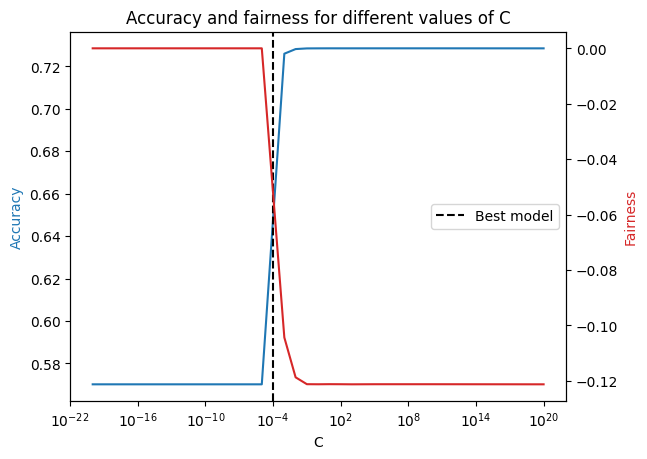

In [34]:
df = pd.read_csv('LR_results_task_1.csv')

# Create plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot
ax1.plot(df_l1_liblinear['C'], df_l1_liblinear['accuracy'], color='tab:blue')
ax2.plot(df_l1_liblinear['C'], df_l1_liblinear['fairness'], color='tab:red')

# Plot horizontal line at C= 0.001
ax1.axvline(x=0.0001, color='black', linestyle='--', label = 'Best model')

# Titles
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax2.set_ylabel('Fairness', color='tab:red')
plt.title('Accuracy and fairness for different values of C')

# Set the x-axis to log scale
ax1.set_xscale('log')

# Legend
ax1.legend(loc='center right')
plt.show()


## Task 2 - Reweighting

We will now repeat task 1, but this time we will reweight the training data to make the training data more fair.

In [149]:
params = {'C': [1e-20, 1e-10, 1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e5, 1e10, 1e20], 
        'penalty': ['l1'], "solver": ['saga']}
        
np.random.seed(1)        
model = LogisticRegression()
results, fairness_results, hordtz_results = get_results_weighted(model, params, splits, sex_splits = sex_splits, hordtz=True)             

params: {'C': 1e-20, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  0
params: {'C': 1e-10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  10
params: {'C': 1e-05, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  20
params: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7264810007080481, fairness: -0.01237140882357124
Iteration:  30
params: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.728392730705688, fairness: -0.031287499191207324
Iteration:  40
params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7289119660136889, fairness: -0.03510646041631704
Iteration:  50
params: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.729454802926599, fairness: -0.03594608314059389
Iteration:  60
params: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7293367949020534, fairness: -0.03613230422008806
Iteration:  70

In [ ]:
# Store results in a dataframe
results_df = pd.DataFrame(columns=['C', 'penalty', 'solver', 'accuracy', 'fairness', 'tpr_1', 'fpr_1', 'tpr_2', 'fpr_2'])
for key, value in results.items():
    params = dict(key)
    results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results[key], 'tpr_1': hordtz_results[key][0], 'fpr_1': hordtz_results[key][1], 'tpr_2': hordtz_results[key][2], 'fpr_2': hordtz_results[key][3]}, ignore_index=True)
    
# Save the results to a csv
results_df.to_csv('LR_results_task_2.csv')

In [216]:
# Load the results
results_df = pd.read_csv('LR_results_task_2.csv')

# Get results when maximizing for accuracy
results_df_l1_acc = results_df_l1[results_df_l1['accuracy'] == results_df_l1['accuracy'].max()]
results_df_l1_acc = results_df_l1_acc.iloc[0]
# Print the results and parameters for maximizing for accuracy
print("Maximizing for accuracy:")
print("Best accuracy: ", results_df_l1_acc['accuracy'])
print("Parameters: ", results_df_l1_acc[['C', 'penalty', 'solver']])
print("Fairness: ", results_df_l1_acc['fairness'])
print()


# Get results when minimizing for the absolute value of fairness
results_df_l1_fair = results_df_l1[results_df_l1['fairness'] == results_df_l1['fairness'].abs().min()]
results_df_l1_fair = results_df_l1_fair.iloc[0]
print("Minimizing for fairness:")
print("Best fairness: ", results_df_l1_fair['fairness'])
print("Parameters: ", results_df_l1_fair[['C', 'penalty', 'solver']])
print("Accuracy: ", results_df_l1_fair['accuracy'])


Maximizing for accuracy:
Best accuracy:  0.7301581307528913
Parameters:  C          100000.0
penalty          l1
solver         saga
Name: 20, dtype: object
Fairness:  -0.0270505676359365

Minimizing for fairness:
Best fairness:  0.0
Parameters:  C           0.0
penalty      l1
solver     saga
Name: 0, dtype: object
Accuracy:  0.5701534104319094


In [217]:
# Reweighing dataset as this seemed to cause an issue
train_weighted = train.copy(deepcopy=True)
RW = Reweighing(unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)
train_weighted = RW.fit_transform(train_weighted)            

# Train
best_params = [(results_df_l1_acc['C'], results_df_l1_acc['penalty'], results_df_l1_acc['solver'])]
model = LogisticRegression(C=best_params[0][0], penalty=best_params[0][1], solver=best_params[0][2], max_iter=1000)
model.fit(train_weighted.features, train_weighted.labels.ravel(), sample_weight=train_weighted.instance_weights)
pickle.dump(model, open("accurate_model_2.pkl", "wb"))

# Evaluate the model on the test set
y_pred = model.predict(test.features)
accuracy = accuracy_score(test.labels, y_pred)
print("Accuracy: {}".format(accuracy))

# Fairness
pred_dataset = test.copy()
pred_dataset.labels = y_pred
fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Fairness: {}".format(fairness.equal_opportunity_difference()))

Accuracy: 0.7280817693188827
Fairness: -0.026326519074355903


In [218]:
# Reweighing dataset as this seemed to cause an issue
train_weighted = train.copy(deepcopy=True)
RW = Reweighing(unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)
train_weighted = RW.fit_transform(train_weighted)

# Train model with most fair parameters on the entire training set
best_fairness_params = [(results_df_l1_fair['C'], results_df_l1_fair['penalty'], results_df_l1_fair['solver'])]
model = LogisticRegression(C=best_fairness_params[0][0], penalty=best_fairness_params[0][1], solver=best_fairness_params[0][2], max_iter=1000)
model.fit(train_weighted.features, train_weighted.labels.ravel(), sample_weight=train_weighted.instance_weights)
pickle.dump(model, open("fair_model_2.pkl", "wb"))

# Evaluate the model using equality of opportunity metric
y_pred = model.predict(test.features)
accuracy = accuracy_score(test.labels, y_pred)
print("Accuracy: {}".format(accuracy))

# Fairness
pred_dataset = test.copy()
pred_dataset.labels = y_pred
fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Fairness: {}".format(fairness.equal_opportunity_difference()))

Accuracy: 0.5685853379152348
Fairness: 0.0


### Plots

#### Varying C

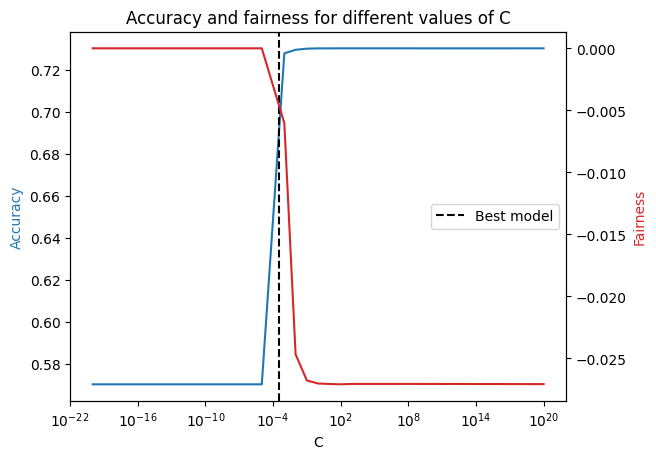

In [82]:
df = pd.read_csv('LR_results_task_2.csv')

# Create plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot
ax1.plot(df_l1_liblinear['C'], df_l1_liblinear['accuracy'], color='tab:blue')
ax2.plot(df_l1_liblinear['C'], df_l1_liblinear['fairness'], color='tab:red')

# Plot horizontal line at C= 0.00015
ax1.axvline(x=0.00035, color='black', linestyle='--', label = 'Best model')

# Titles
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax2.set_ylabel('Fairness', color='tab:red')
plt.title('Accuracy and fairness for different values of C')

# Legend
ax1.legend(loc='center right')

# Set the x-axis to log scale
ax1.set_xscale('log')
plt.show()


### ROC curves

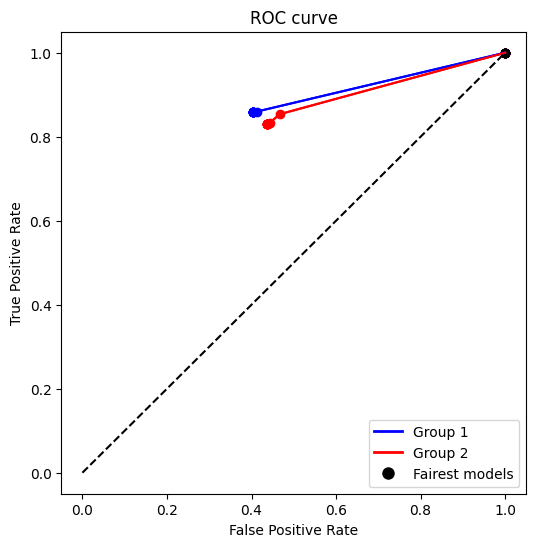

In [329]:
# Plot ROC curves all in one plot
fig, ax = plt.subplots(figsize=(6, 6))
results_df = pd.read_csv('LR_results_task_2.csv')

# Find models with fairness of 0
fairness_0 = results_df[results_df['fairness'] == 0]

# Plot ROC curves
ax.plot(results_df['fpr_1'], results_df['tpr_1'], label="Group 1", color="blue")
ax.plot(results_df['fpr_2'], results_df['tpr_2'], label="Group 2", color="red")

# Plot points
ax.scatter(results_df['fpr_1'], results_df['tpr_1'], color='blue')
ax.scatter(results_df['fpr_2'], results_df['tpr_2'], color='red')

# Plot line
ax.plot(results_df['fpr_1'], results_df['tpr_1'], color='blue')
ax.plot(results_df['fpr_2'], results_df['tpr_2'], color='red')

# Plot models with fairness of 0 as a black circle
ax.scatter(fairness_0['fpr_1'], fairness_0['tpr_1'], color='black', marker='o')
ax.scatter(fairness_0['fpr_2'], fairness_0['tpr_2'], color='black', marker='o')


# Plot diagonal line
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

# Titles
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')

# Create legend with the first line blue and the second line red and third point a pink circle
legend_elements = [plt.Line2D([0], [0], color='blue', lw=2, label='Group 1'),
                     plt.Line2D([0], [0], color='red', lw=2, label='Group 2')]

# Add circle to legend marked as optimal model
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Fairest models',
                            markerfacecolor='black', markersize=10))                     
ax.legend(handles=legend_elements, loc='lower right')


plt.show()


## Task 3 - Accuracy-Fairness Trade-Off

### **Introduction**

Our metric of choice to find the best trade-off between accuracy and fairness is inspired by the paper "Equality of Opportunity in Supervised Learning" by Hardt et al. (2016). The link to the paper is [here](https://arxiv.org/pdf/1610.02413.pdf).

The metric of choice called weighted accurac-fairness (WAF) is defined as follows:

$$ WAF = (1-weight)*accuracy + weight*|fairness| $$


### Best standard model

In [156]:
params = {'C': [1e-20, 1e-10, 1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e5, 1e10, 1e20], 
        'penalty': ['l1'], "solver": ['saga']}

np.random.seed(1)
model = LogisticRegression()
results_standard, fairness_results_standard, hordtz_results_standard = get_results(model, params, splits, sex_splits = sex_splits, hordtz=True)             

params: {'C': 1e-20, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  0
params: {'C': 1e-10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  10
params: {'C': 1e-05, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  20
params: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7230115647864055, fairness: -0.11151804347849925
Iteration:  30
params: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.725041302808591, fairness: -0.12923894394162216
Iteration:  40
params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.725584139721501, fairness: -0.13251286117389538
Iteration:  50
params: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7257021477460467, fairness: -0.13234696957733316
Iteration:  60
params: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7257021477460467, fairness: -0.13226910614978515
Iteration:  70


In [157]:
# Store results in a dataframe
results_df = pd.DataFrame(columns=['C', 'penalty', 'solver', 'accuracy', 'fairness', 'tpr_1', 'fpr_1', 'tpr_2', 'fpr_2'])
for key, value in results_standard.items():
    params = dict(key)
    results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results_standard[key], 'tpr_1': hordtz_results_standard[key][0], 
                                    'fpr_1': hordtz_results_standard[key][1], 'tpr_2': hordtz_results_standard[key][2], 'fpr_2': hordtz_results_standard[key][3]}, ignore_index=True)

# Save the results to a csv
results_df.to_csv('LR_results_standard_task_3.csv')

C:\Users\ashou\AppData\Local\Temp\ipykernel_1952\3120534494.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results_standard[key], 'tpr_1': hordtz_results_standard[key][0],
C:\Users\ashou\AppData\Local\Temp\ipykernel_1952\3120534494.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results_standard[key], 'tpr_1': hordtz_results_standard[key][0],
C:\Users\ashou\AppData\Local\Temp\ipykernel_1952\3120534494.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

In [219]:
# Applying best weight posteriori
results_df = pd.read_csv('LR_results_standard_task_3.csv')
weight = 0.5
results_df["custom_metric_simple"] = results_df.apply(lambda row: custom_metric_simple(row['accuracy'], row['fairness'], weight), axis=1)                                                                             

# Save the results to a csv
results_df.to_csv('LR_results_standard_task_3.csv')


In [220]:
# Load data
results_df = pd.read_csv('LR_results_standard_task_3.csv')


# Find model with the highest simple custom metric
best_custom_metric_simple = results_df[results_df['custom_metric_simple'] == results_df['custom_metric_simple'].max()]
print("Best parameters: ")
print("C: {}".format(best_custom_metric_simple['C'].values[0]))
print("Penalty: {}".format(best_custom_metric_simple['penalty'].values[0]))
print("Solver: {}".format(best_custom_metric_simple['solver'].values[0]))
print()

# Find the index of best_custom_metric_simple in results_df
best_custom_metric_simple_index = results_df[results_df['custom_metric_simple'] == results_df['custom_metric_simple'].max()].index[0]


# Train model with most fair parameters on the entire training set
model = LogisticRegression(C=best_custom_metric_simple['C'].values[0], penalty=best_custom_metric_simple['penalty'].values[0], solver=best_custom_metric_simple['solver'].values[0],
                            max_iter=1000)
model.fit(train.features, train.labels.ravel())
pickle.dump(model, open('LR_model_standard_simple_task_3.pkl', 'wb'))

# Evaluate the model on the test set
y_pred = model.predict(test.features)
accuracy = accuracy_score(test.labels, y_pred)
print("Accuracy: {}".format(accuracy))

# Fairness
pred_dataset = test.copy()
pred_dataset.labels = y_pred
fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Fairness: {}".format(fairness.equal_opportunity_difference()))

# Custom metric simple
custom_met_simple = custom_metric_simple(accuracy, fairness.equal_opportunity_difference(), weight)
print("Custom metric simple: {}".format(custom_met_simple))


Best parameters: 
C: 0.001
Penalty: l1
Solver: saga

Accuracy: 0.7254383646136223
Fairness: -0.09791655526561727
Custom metric simple: 0.3137609046740025


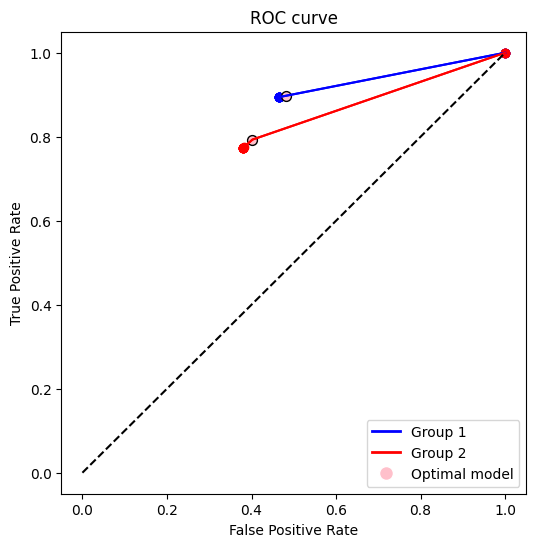

In [93]:
# Plot ROC curves all in one plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot ROC curves
ax.plot(results_df['fpr_1'], results_df['tpr_1'], label="Group 1", color="blue")
ax.plot(results_df['fpr_2'], results_df['tpr_2'], label="Group 2", color="red")

# Plot points
ax.scatter(results_df['fpr_1'], results_df['tpr_1'], color='blue')
ax.scatter(results_df['fpr_2'], results_df['tpr_2'], color='red')

# Plot line
ax.plot(results_df['fpr_1'], results_df['tpr_1'], color='blue')
ax.plot(results_df['fpr_2'], results_df['tpr_2'], color='red')

# Plot the point corresponding to best_custom_metric in pink and label it "optimal model"
ax.scatter(results_df['fpr_1'][best_custom_metric_simple_index], results_df['tpr_1'][best_custom_metric_simple_index], color='pink', label="Optimal model",
           marker='o', s=50, edgecolors='black')
ax.scatter(results_df['fpr_2'][best_custom_metric_simple_index], results_df['tpr_2'][best_custom_metric_simple_index], color='pink', 
              marker='o', s=50, edgecolors='black')

# Plot diagonal line
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

# Titles
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')

# Create legend with the first line blue and the second line red and third point a pink circle
legend_elements = [plt.Line2D([0], [0], color='blue', lw=2, label='Group 1'),
                     plt.Line2D([0], [0], color='red', lw=2, label='Group 2')]

# Add circle to legend marked as optimal model
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Optimal model',
                            markerfacecolor='pink', markersize=10))                     
ax.legend(handles=legend_elements, loc='lower right')


plt.show()


#### Exploring weights

##### Simple metric

In [337]:
# Create weight space from 0 to 1
weight_space = np.linspace(0, 1, 100)

# For each weight, loop through the results, find the custom metric and then find the max
# Store the max custom metric, the accuracy and fairness for that weight, and the weight
weight_results = []
results = pd.read_csv('LR_results_standard_task_3.csv')

for weight in weight_space:
    # Create a copy of dataframe
    df = results.copy()
    # Calculate the custom metric
    df['custom_metric'] = df.apply(lambda x: custom_metric_simple(x['accuracy'], x['fairness'], weight), axis=1)
    # Find the max custom metric
    max_custom_metric = df['custom_metric'].max()
    # Find the accuracy and fairness for that max custom metric
    max_accuracy = df[df['custom_metric'] == max_custom_metric]['accuracy'].values[0]
    max_fairness = df[df['custom_metric'] == max_custom_metric]['fairness'].values[0]
    # Add the max custom metric, accuracy, fairness, and weight to the list
    weight_results.append([max_custom_metric, max_accuracy, max_fairness, weight])

# Convert the list to a dataframe
weight_results = pd.DataFrame(weight_results, columns=['custom_metric', 'accuracy', 'fairness', 'weight'])


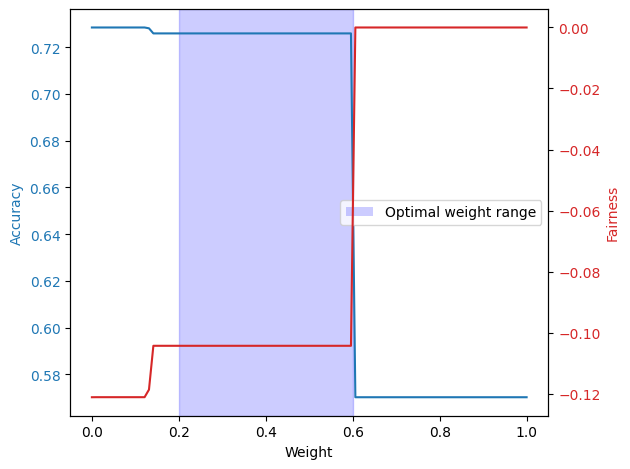

In [346]:
# Plot the accuracy and fairness for each weight, where accuracy and fairness are on two different y-axes to the left and right
fig, ax1 = plt.subplots()

# Plot
ax1.plot(weight_results['weight'], weight_results['accuracy'], color='tab:blue')

# Draw shaded rectangle
ax1.axvspan(0.2, 0.6, alpha=0.2, color='blue', label='Optimal weight range')

# Label axes
ax1.set_xlabel('Weight')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()

# Plot
ax2.plot(weight_results['weight'], weight_results['fairness'], color='tab:red')
ax2.set_ylabel('Fairness', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
fig.tight_layout()

# Create legend for shaded rectangle
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.2, label='Optimal weight range')]
ax1.legend(handles=legend_elements, loc='center right')

plt.show()


### Best reweighted model

In [169]:
params = {'C': [1e-20, 1e-10, 1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e5, 1e10, 1e20], 
        'penalty': ['l1'], "solver": ['saga']}       

np.random.seed(1)
model = LogisticRegression()
results_standard, fairness_results_standard, hordtz_results_standard = get_results_weighted(model, params, splits, sex_splits = sex_splits, hordtz=True)             

params: {'C': 1e-20, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  0
params: {'C': 1e-10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  10
params: {'C': 1e-05, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.5712296436157659, fairness: 0.0
Iteration:  20
params: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7264810007080481, fairness: -0.01237140882357124
Iteration:  30
params: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.728392730705688, fairness: -0.031287499191207324
Iteration:  40
params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7289119660136889, fairness: -0.03510646041631704
Iteration:  50
params: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.729454802926599, fairness: -0.03594608314059389
Iteration:  60
params: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}, accuracy: 0.7293367949020534, fairness: -0.03613230422008806
Iteration:  70

In [170]:
# Store results in a dataframe
weight = 0.5
results_df = pd.DataFrame(columns=['C', 'penalty', 'solver', 'accuracy', 'fairness', 'tpr_1', 'fpr_1', 'tpr_2', 'fpr_2'])
for key, value in results_standard.items():
    params = dict(key)
    results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results_standard[key], 'tpr_1': hordtz_results_standard[key][0], 
                                    'fpr_1': hordtz_results_standard[key][1], 'tpr_2': hordtz_results_standard[key][2], 'fpr_2': hordtz_results_standard[key][3]}, ignore_index=True)
results_df["custom_metric_simple"] = results_df.apply(lambda row: custom_metric_simple(row['accuracy'], row['fairness'], weight), axis=1)                                                                             
    
# Save the results to a csv
results_df.to_csv('LR_results_weighted_task_3.csv')

C:\Users\ashou\AppData\Local\Temp\ipykernel_1952\2231229249.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results_standard[key], 'tpr_1': hordtz_results_standard[key][0],
C:\Users\ashou\AppData\Local\Temp\ipykernel_1952\2231229249.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'C': params['C'], 'penalty': params['penalty'], 'solver': params['solver'], 'accuracy': value, 'fairness': fairness_results_standard[key], 'tpr_1': hordtz_results_standard[key][0],
C:\Users\ashou\AppData\Local\Temp\ipykernel_1952\2231229249.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

In [171]:
# Applying best weight posteriori
results_df = pd.read_csv('LR_results_weighted_task_3.csv')
weight = 0.5
results_df["custom_metric_simple"] = results_df.apply(lambda row: custom_metric_simple(row['accuracy'], row['fairness'], weight), axis=1)                                                                             

# Save the results to a csv
results_df.to_csv('LR_results_weighted_task_3.csv')


In [221]:
# Find model with the highest simple custom metric

# Load the results
results_df = pd.read_csv('LR_results_weighted_task_3.csv')

best_custom_metric_simple = results_df[results_df['custom_metric_simple'] == results_df['custom_metric_simple'].max()]
print("Best parameters simple: ")
print(best_custom_metric_simple[['C', 'penalty', 'solver']])

# Print the best custom metrics
print("Best custom metric simple: {}".format(best_custom_metric_simple['custom_metric_simple'].values[0]))

# Find the index of best_custom_metric_simple in results_df
best_custom_metric_simple_index = results_df[results_df['custom_metric_simple'] == results_df['custom_metric_simple'].max()].index[0]


# Train model with most fair parameters on the entire training set
model = LogisticRegression(C=best_custom_metric_simple['C'].values[0], penalty=best_custom_metric_simple['penalty'].values[0], solver=best_custom_metric_simple['solver'].values[0], max_iter=1000)
model.fit(train_weighted.features, train_weighted.labels.ravel(), sample_weight=train_weighted.instance_weights)
pickle.dump(model, open('LR_model_weighted_simple_task_3.pkl', 'wb'))

# Evaluate the model on the test set
y_pred = model.predict(test.features)
accuracy = accuracy_score(test.labels, y_pred)
print("Accuracy: {}".format(accuracy))

# Fairness
pred_dataset = test.copy()
pred_dataset.labels = y_pred
fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Fairness: {}".format(fairness.equal_opportunity_difference()))

# Custom metric simple
custom_met_simple = custom_metric_simple(accuracy, fairness.equal_opportunity_difference(), weight=0.5)
print("Custom metric simple: {}".format(custom_met_simple))

Best parameters simple: 
       C penalty solver
6  0.001      l1   saga
Best custom metric simple: 0.360866871333531
Accuracy: 0.7243479601727024
Fairness: 0.00048101435482261756
Custom metric simple: 0.3619334729089399


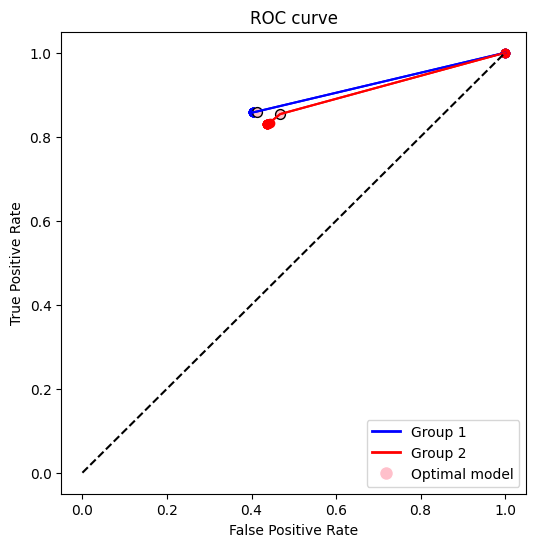

In [99]:
# Plot ROC curves all in one plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot ROC curves
ax.plot(results_df['fpr_1'], results_df['tpr_1'], label="Group 1", color="blue")
ax.plot(results_df['fpr_2'], results_df['tpr_2'], label="Group 2", color="red")

# Plot points
ax.scatter(results_df['fpr_1'], results_df['tpr_1'], color='blue')
ax.scatter(results_df['fpr_2'], results_df['tpr_2'], color='red')

# Plot line
ax.plot(results_df['fpr_1'], results_df['tpr_1'], color='blue')
ax.plot(results_df['fpr_2'], results_df['tpr_2'], color='red')

# Plot the point corresponding to best_custom_metric in pink and label it "optimal model"
ax.scatter(results_df['fpr_1'][best_custom_metric_simple_index], results_df['tpr_1'][best_custom_metric_simple_index], color='pink', label="Optimal model",
           marker='o', s=50, edgecolors='black')
ax.scatter(results_df['fpr_2'][best_custom_metric_simple_index], results_df['tpr_2'][best_custom_metric_simple_index], color='pink', 
              marker='o', s=50, edgecolors='black')

# Plot diagonal line
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

# Titles
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')

# Create legend with the first line blue and the second line red and third point a pink circle
legend_elements = [plt.Line2D([0], [0], color='blue', lw=2, label='Group 1'),
                     plt.Line2D([0], [0], color='red', lw=2, label='Group 2')]

# Add circle to legend marked as optimal model
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Optimal model',
                            markerfacecolor='pink', markersize=10))                     
ax.legend(handles=legend_elements, loc='lower right')


plt.show()


#### Exploring weights

##### Simple metric

In [349]:
# Create weight space from 0 to 1
weight_space = np.linspace(0, 1, 100)

# For each weight, loop through the results, find the custom metric and then find the max
# Store the max custom metric, the accuracy and fairness for that weight, and the weight
weight_results = []
results = pd.read_csv('LR_results_weighted_task_3.csv')#
results = results[results['penalty'] == 'l1']
for weight in weight_space:
    # Create a copy of dataframe
    df = results.copy()
    # Calculate the custom metric
    df['custom_metric'] = df.apply(lambda x: custom_metric_simple(x['accuracy'], x['fairness'], weight), axis=1)
    # Find the max custom metric
    max_custom_metric = df['custom_metric'].max()
    # Find the accuracy and fairness for that max custom metric
    max_accuracy = df[df['custom_metric'] == max_custom_metric]['accuracy'].values[0]
    max_fairness = df[df['custom_metric'] == max_custom_metric]['fairness'].values[0]
    # Add the max custom metric, accuracy, fairness, and weight to the list
    weight_results.append([max_custom_metric, max_accuracy, max_fairness, weight])

# Convert the list to a dataframe
weight_results = pd.DataFrame(weight_results, columns=['custom_metric', 'accuracy', 'fairness', 'weight'])


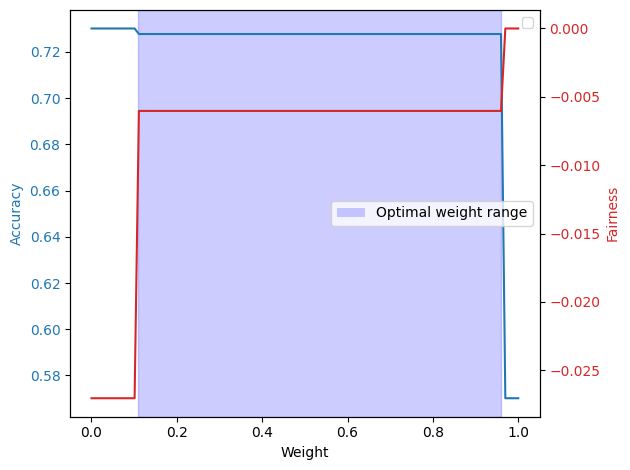

In [354]:
# Plot the accuracy and fairness for each weight, where accuracy and fairness are on two different y-axes to the left and right
fig, ax1 = plt.subplots()

# Plot
ax1.plot(weight_results['weight'], weight_results['accuracy'], color='tab:blue')

# Draw shaded rectangle
ax1.axvspan(0.11, 0.96, alpha=0.2, color='blue', label='Optimal weight range')


# Label axes
ax1.set_xlabel('Weight')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()

# Legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.2, label='Optimal weight range')]
ax1.legend(handles=legend_elements, loc='center right')


# Plot
ax2.plot(weight_results['weight'], weight_results['fairness'], color='tab:red')
ax2.set_ylabel('Fairness', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
fig.tight_layout()
plt.legend()
plt.show()


#### Accuracy and fairness vs C for both the standard and reweighed model

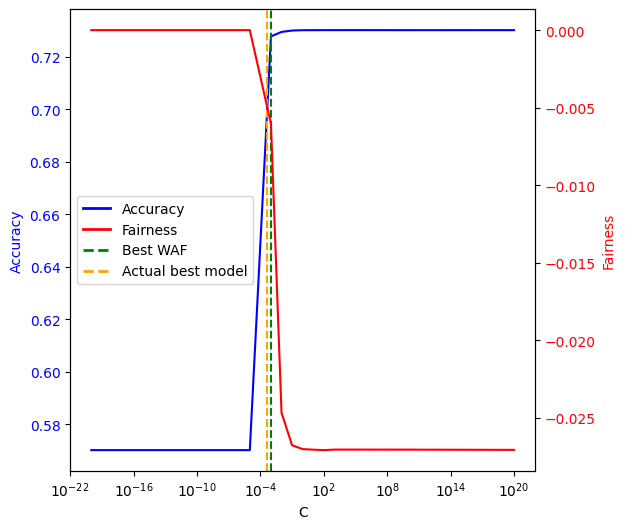

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

df = pd.read_csv('LR_results_weighted_task_3.csv')

df['custom_metric'] = df.apply(lambda x: custom_metric_simple(x['accuracy'], x['fairness'], weight=0.2), axis=1)

# Find the accuracy and fairness for the best model
best_model = df[df['custom_metric'] == df['custom_metric'].max()]
acc = best_model['accuracy'].values[0]
fairness = best_model['fairness'].values[0]

# Plot accuracy and fairness against C for the L1 penalty, with accuracy and fairness on two different y-axes
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot accuracy
ax1.plot(df['C'], df['accuracy'], color='blue')
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot fairness
ax2 = ax1.twinx()
ax2.plot(df['C'], df['fairness'], color='red')
ax2.set_ylabel('Fairness', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot a vertical line at the best C
ax1.axvline(best_model['C'].values[0], color='green', linestyle='--', label='Best C')
ax1.axvline(0.0004, color='orange', linestyle='--', label='Actual best model')


# Use log scale for C
ax1.set_xscale('log')

# Create legend
legend_elements = [plt.Line2D([0], [0], color='blue', lw=2, label='Accuracy'),
                        plt.Line2D([0], [0], color='red', lw=2, label='Fairness'),
                        plt.Line2D([0], [0], color='green', lw=2, linestyle='--', label='Best WAF'),
                        plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label='Actual best model')]
# Plot legend at lowe rmiddle
ax1.legend(handles=legend_elements, loc='center left')


plt.show()


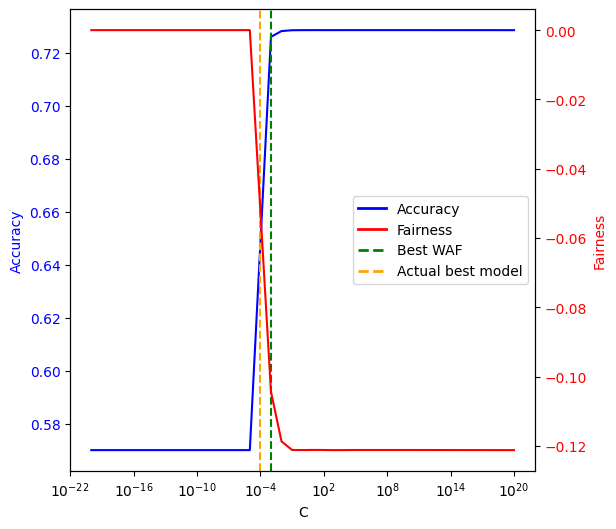

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

df = pd.read_csv('LR_results_standard_task_3.csv')
df = df[df['penalty'] == 'l1']
df['custom_metric'] = df.apply(lambda x: custom_metric_simple(x['accuracy'], x['fairness'], weight=0.2), axis=1)

# Find the accuracy and fairness for the best model
best_model = df[df['custom_metric'] == df['custom_metric'].max()]
acc = best_model['accuracy'].values[0]
fairness = best_model['fairness'].values[0]

# Plot accuracy and fairness against C for the L1 penalty, with accuracy and fairness on two different y-axes
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot accuracy
ax1.plot(df['C'], df['accuracy'], color='blue')
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot fairness
ax2 = ax1.twinx()
ax2.plot(df['C'], df['fairness'], color='red')
ax2.set_ylabel('Fairness', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot a vertical line at the best C
ax1.axvline(best_model['C'].values[0], color='green', linestyle='--', label='Best WAF')
ax1.axvline(0.0001, color='orange', linestyle='--', label='Actual best model')


# Use log scale for C
ax1.set_xscale('log')

# Create legend
legend_elements = [plt.Line2D([0], [0], color='blue', lw=2, label='Accuracy'),
                        plt.Line2D([0], [0], color='red', lw=2, label='Fairness'),
                        plt.Line2D([0], [0], color='green', lw=2, linestyle='--', label='Best WAF'),
                        plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label='Actual best model')]
# Plot legend at lowe rmiddle
ax1.legend(handles=legend_elements, loc='center right')


plt.show()


## Extensions

### All results

In [320]:
# Load all 6 models
import pickle

model_1 = pickle.load(open('accurate_model_1.pkl', 'rb'))
model_2 = pickle.load(open('fair_model_1.pkl', 'rb'))
model_3 = pickle.load(open('accurate_model_2.pkl', 'rb'))
model_4 = pickle.load(open('fair_model_2.pkl', 'rb'))
model_5 = pickle.load(open('LR_model_standard_simple_task_3.pkl', 'rb'))
model_6 = pickle.load(open('LR_model_weighted_simple_task_3.pkl', 'rb'))


In [223]:
# Get predictions for each model
columns=['model', 'accuracy', 'fairness', 'tpr_1', 'fpr_1', 'tpr_2', 'fpr_2', 'custom_metric']
results = pd.DataFrame({c: [] for c in columns})
models = [model_1, model_2, model_3, model_4, model_5, model_6]
model_names = ["model 1", "model 2", "model 3", "model 4", "model 5", "model 6"]
weight = 0.5
for i in range(len(models)):
    if True:
        # Finding predictions then fairness and accuracy
        y_pred = models[i].predict(test.features)
        pred_dataset = test.copy()
        pred_dataset.labels = y_pred
        fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        accuracy = accuracy_score(test.labels, y_pred)

        # Finding TPRs and FPRs for both groups
        rates = find_tpr_fpr(y_pred, test.labels, sex_test)
        tpr_1, fpr_1, tpr_2, fpr_2 = rates[0][0], rates[0][1], rates[1][0], rates[1][1]


        results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(), 
                                 "tpr_1": tpr_1, "fpr_1": fpr_1, "tpr_2": tpr_2, "fpr_2": fpr_2, 
                                 "custom_simple_metric": custom_metric_simple(accuracy, fairness.equal_opportunity_difference(), weight)}, ignore_index=True)        
# Save results
results.to_csv('all_task_results.csv', index=False)        

C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\2570039212.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\2570039212.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\2570039212.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\A

In [224]:
# View results
results

,model,accuracy,fairness,tpr_1,fpr_1,tpr_2,fpr_2,custom_metric,custom_simple_metric
0,model 1,0.728126,-0.117415,0.894852,0.462547,0.777437,0.385852,NaN,0.305356
1,model 2,0.568585,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.284293
2,model 3,0.728082,-0.026327,0.857912,0.403558,0.831585,0.444817,NaN,0.350878
3,model 4,0.568585,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.284293
4,model 5,0.725438,-0.097917,0.887253,0.459094,0.789336,0.403107,NaN,0.313761
5,model 6,0.724348,0.000481,0.842423,0.389455,0.842904,0.464155,NaN,0.361933


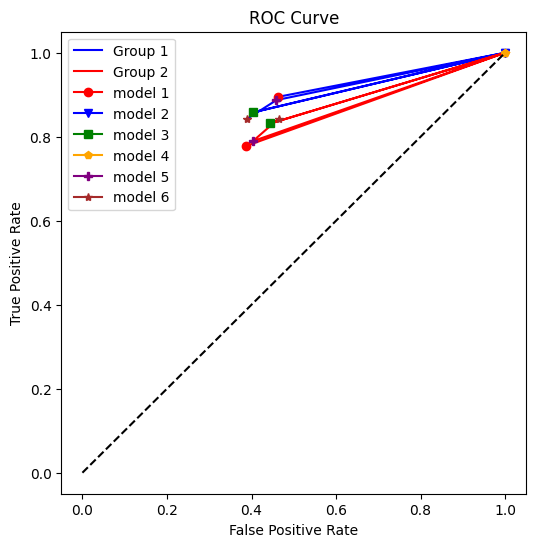

In [225]:
# Plot ROC curves for each model on the same plot

# Plot TPR against FPR for all the models and each group, different colour for each group
plt.figure(figsize=(6, 6))
plt.plot(results['fpr_1'], results['tpr_1'], label='Group 1', color="blue")
plt.plot(results['fpr_2'], results['tpr_2'],  label='Group 2', color="red")

# For each of the model plot points for the TPR and FPR for each group
# Colour the points based on the model, label the points with the model name
model_names = ["model 1", "model 2", "model 3", "model 4", "model 5", "model 6"]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
markers = ['o', 'v', 's', 'p', 'P', '*']
for i in range(len(results)):
    plt.plot(results['fpr_1'][i], results['tpr_1'][i], color=colors[i], marker=markers[i], label=model_names[i])
    plt.plot(results['fpr_2'][i], results['tpr_2'][i], color=colors[i], marker=markers[i])

# Plot the line for a random model
plt.plot([0, 1], [0, 1], 'k--')

# Label axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Testing on the NY data

In [306]:
# Get predictions for each model
columns=['model', 'accuracy', 'fairness', 'tpr_1', 'fpr_1', 'tpr_2', 'fpr_2', 'custom_metric']
results = pd.DataFrame({c: [] for c in columns})
weight = 0.5
for i in range(len(models)):
    # Finding predictions then fairness and accuracy
    y_pred = models[i].predict(dataset_ny.features)
    pred_dataset = dataset_ny.copy()
    pred_dataset.labels = y_pred
    fairness = ClassificationMetric(dataset_ny, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    accuracy = accuracy_score(dataset_ny.labels, y_pred)

    # Finding TPRs and FPRs for both groups
    rates = find_tpr_fpr(y_pred, dataset_ny.labels, sexes_ny)
    tpr_1, fpr_1, tpr_2, fpr_2 = rates[0][0], rates[0][1], rates[1][0], rates[1][1]


    results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(), 
                                "tpr_1": tpr_1, "fpr_1": fpr_1, "tpr_2": tpr_2, "fpr_2": fpr_2, 
                                "custom_simple_metric": custom_metric_simple(accuracy, fairness.equal_opportunity_difference(), weight)}, ignore_index=True)        
# Save results
results.to_csv('NY_task_results_no_penalty.csv', index=False)        

C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\3351646846.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\3351646846.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\3351646846.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\A

In [308]:
# View results
results

,model,accuracy,fairness,tpr_1,fpr_1,tpr_2,fpr_2,custom_metric,custom_simple_metric
0,model 1,0.739326,-0.116034,0.897808,0.479784,0.781773,0.329218,NaN,0.311646
1,model 2,0.571355,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.285678
2,model 3,0.741307,-0.023616,0.860541,0.414827,0.836925,0.392053,NaN,0.358845
3,model 4,0.571355,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.285678
4,model 5,0.681498,-0.007394,0.947173,0.655664,0.939778,0.677322,NaN,0.337052
5,model 6,0.739013,-0.007027,0.862120,0.419666,0.855094,0.421090,NaN,0.365993


C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\834690422.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results['fpr_1'][i], results['tpr_1'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\834690422.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results['fpr_2'][i], results['tpr_2'][i], 'o', color=colors[i], marker=markers[i])


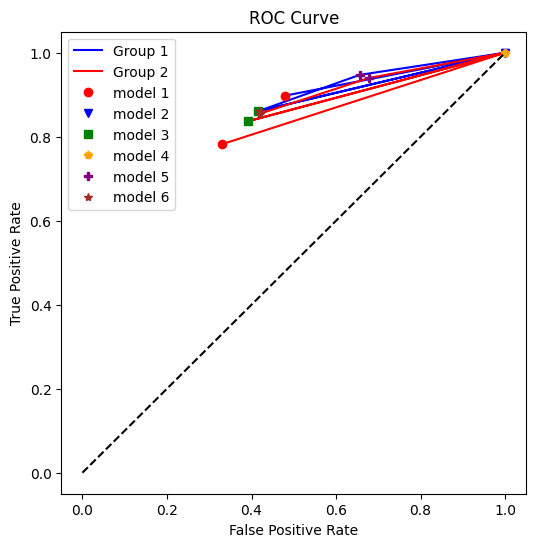

In [309]:
# Plot ROC curves for each model on the same plot

# Plot TPR against FPR for all the models and each group, different colour for each group
plt.figure(figsize=(6, 6))
plt.plot(results['fpr_1'], results['tpr_1'], label='Group 1', color="blue")
plt.plot(results['fpr_2'], results['tpr_2'],  label='Group 2', color="red")

# For each of the model plot points for the TPR and FPR for each group
# Colour the points based on the model, label the points with the model name
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
markers = ['o', 'v', 's', 'p', 'P', '*']
for i in range(len(results)):
    plt.plot(results['fpr_1'][i], results['tpr_1'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])
    plt.plot(results['fpr_2'][i], results['tpr_2'][i], 'o', color=colors[i], marker=markers[i])

# Plot the line for a random model
plt.plot([0, 1], [0, 1], 'k--')

# Label axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\2124230598.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results['fairness'][i], results['accuracy'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])


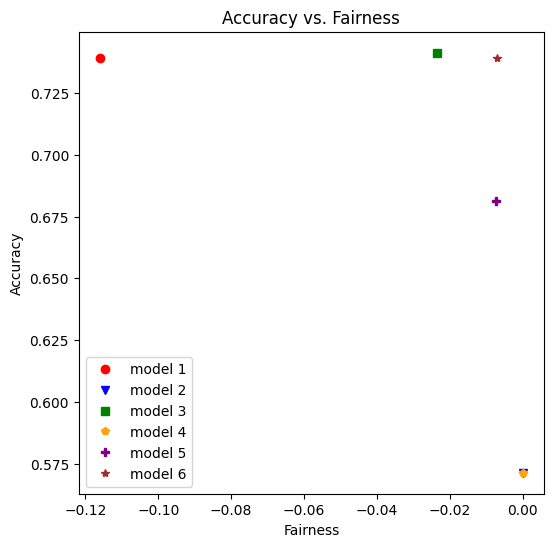

In [310]:
# Plot accuracy vs. fairness for each model
plt.figure(figsize=(6, 6))

# Plot each model with a different colour
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
markers = ['o', 'v', 's', 'p', 'P', '*']
for i in range(len(results)):
    plt.plot(results['fairness'][i], results['accuracy'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])    


# Label axes
plt.xlabel('Fairness')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Fairness')
plt.legend()
plt.show()


## Leaving the sensitive attribute out of the features

Here, we will leave the sensitive attribute out of the features and observe how this changes the performance of the models. To do this, we will set the sensitive attribute to be constant (-1) at test time. During evaluation, we will include the actual sensitive attribute in the features.

In [311]:
# For the variable called test, set the SEX attribute to -1
ind = features_names.index("SEX")
test_remove_sens = test.copy(deepcopy=True)
test_remove_sens.features[:, ind] = -1

# Get predictions for each model
columns=['model', 'accuracy', 'fairness', 'tpr_1', 'fpr_1', 'tpr_2', 'fpr_2', 'custom_metric']
results = pd.DataFrame({c: [] for c in columns})
weight_1 = 0.2
weight_2 = 0.5
for i in range(len(models)):
    y_pred = models[i].predict(test_remove_sens.features)
    pred_dataset = test_remove_sens.copy(deepcopy=True)
    pred_dataset.labels = y_pred
    # Reinclude the actual sensitive attributes
    pred_dataset.features[:, ind] = test.features[:, ind]
    # Evaluate the model using equality of opportunity metric and accuracy
    fairness = ClassificationMetric(test, pred_dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    accuracy = accuracy_score(test.labels, y_pred)

    # Finding TPRs and FPRs for both groups
    rates = find_tpr_fpr(y_pred, test.labels, sex_test)
    tpr_1, fpr_1, tpr_2, fpr_2 = rates[0][0], rates[0][1], rates[1][0], rates[1][1]
    results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(), 
                                "tpr_1": tpr_1, "fpr_1": fpr_1, "tpr_2": tpr_2, "fpr_2": fpr_2, 
                                "custom_simple_metric": custom_metric_simple(accuracy, fairness.equal_opportunity_difference(), weight_2)}, ignore_index=True)        


C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\1167693699.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\1167693699.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\1167693699.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model': model_names[i], 'accuracy': accuracy, 'fairness': fairness.equal_opportunity_difference(),
C:\Users\ashou\A

In [313]:
# Save results
results.to_csv('Removing_Gender_Task.csv', index=False)

In [312]:
results

,model,accuracy,fairness,tpr_1,fpr_1,tpr_2,fpr_2,custom_metric,custom_simple_metric
0,model 1,0.719414,0.016516,0.895030,0.464013,0.911546,0.571500,NaN,0.351449
1,model 2,0.570843,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.285422
2,model 3,0.725240,0.016924,0.858256,0.405718,0.875180,0.506202,NaN,0.354158
3,model 4,0.570843,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.285422
4,model 5,0.667933,0.001782,0.953068,0.662968,0.954850,0.750889,NaN,0.333076
5,model 6,0.723830,0.016358,0.860586,0.412939,0.876945,0.511309,NaN,0.353736


C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\3298502717.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results['fpr_1'][i], results['tpr_1'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])
C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\3298502717.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results['fpr_2'][i], results['tpr_2'][i], 'o', color=colors[i], marker=markers[i])


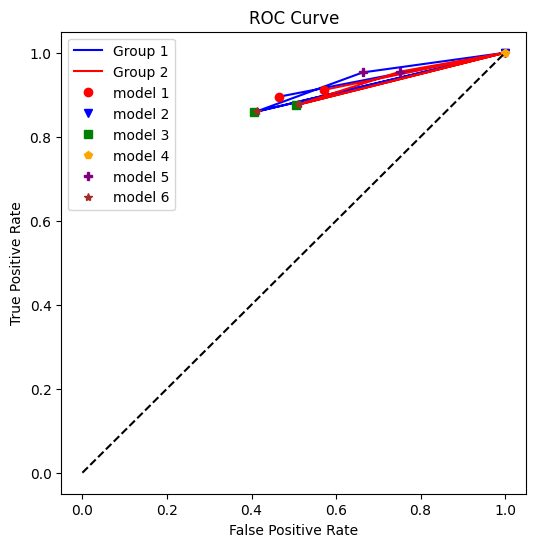

In [314]:
# Plot ROC curves for each model on the same plot

# Plot TPR against FPR for all the models and each group, different colour for each group
plt.figure(figsize=(6, 6))
plt.plot(results['fpr_1'], results['tpr_1'], label='Group 1', color="blue")
plt.plot(results['fpr_2'], results['tpr_2'],  label='Group 2', color="red")

# For each of the model plot points for the TPR and FPR for each group
# Colour the points based on the model, label the points with the model name
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
markers = ['o', 'v', 's', 'p', 'P', '*']
model_names = ["model 1", "model 2", "model 3", "model 4", "model 5", "model 6"]
for i in range(len(results)):
    plt.plot(results['fpr_1'][i], results['tpr_1'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])
    plt.plot(results['fpr_2'][i], results['tpr_2'][i], 'o', color=colors[i], marker=markers[i])    


# Plot the line for a random model
plt.plot([0, 1], [0, 1], 'k--')

# Label axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

C:\Users\ashou\AppData\Local\Temp\ipykernel_8816\2124230598.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results['fairness'][i], results['accuracy'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])


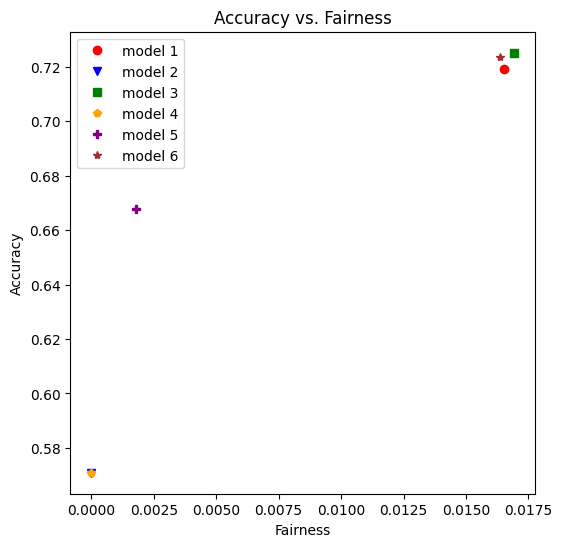

In [315]:
# Plot accuracy vs. fairness for each model
plt.figure(figsize=(6, 6))

# Plot each model with a different colour
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
markers = ['o', 'v', 's', 'p', 'P', '*']
for i in range(len(results)):
    plt.plot(results['fairness'][i], results['accuracy'][i], 'o', color=colors[i], label=model_names[i], marker=markers[i])    


# Label axes
plt.xlabel('Fairness')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Fairness')
plt.legend()
plt.show()
